# CAPTCHA Recognition Pipeline with Segmentation

This notebook integrates the character segmentation approach from `segmentation.py` with a CNN-based character recognition model.

## 1. Environment Setup

In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Character set
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
VOCAB_SIZE = len(CHARS)
ch2id = {ch: i for i, ch in enumerate(CHARS)}
id2ch = {i: ch for ch, i in ch2id.items()}

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Characters: {CHARS}")

device: cuda
Vocabulary size: 36
Characters: 0123456789abcdefghijklmnopqrstuvwxyz


## 2. Import Segmentation Functions. Try hyper-parameter tuning with segment_characters method

Import the segmentation functions directly from `segmentation_v2.py`.

In [3]:
# Import segmentation functions from segmentation.py
from segmentation_v2 import segment_characters

## 3. Character Dataset

Dataset class that segments CAPTCHAs and provides individual character images for training.

In [5]:
class SegmentedCharDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_size=(32, 32)):
        """
        Args:
            img_paths: List of CAPTCHA image paths
            transform: Optional transform to be applied on characters
            target_size: Target size for character images (H, W)
        """
        self.img_paths = img_paths
        self.transform = transform
        self.target_size = target_size
        
        # Pre-segment all images and build character dataset
        self.characters = []  # List of (char_image, label)
        self._build_dataset()
    
    def _build_dataset(self):
        print("Segmenting CAPTCHA images...")
        for img_path in tqdm(self.img_paths):
            try:
                gt_text = Path(img_path).stem.split('-')[0]
                char_images, _seg_labels = segment_characters(img_path)

                if len(char_images) == 0:
                    continue

                # Align using ground truth (trusted) and left-to-right order from segmentation
                n = min(len(char_images), len(gt_text))
                if n < len(gt_text) or n < len(char_images):
                    print(f"[INFO] Mismatch kept={len(char_images)} vs GT={len(gt_text)} for {Path(img_path).name}; using first {n} aligned pairs")

                for k in range(n):
                    ch = gt_text[k].lower()
                    if ch in ch2id:
                        self.characters.append((char_images[k], ch))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        print(f"Total characters extracted: {len(self.characters)}")
    
    def __len__(self):
        return len(self.characters)
    
    def __getitem__(self, idx):
        char_img, label = self.characters[idx]
        
        # Preprocess character image
        char_img = self._preprocess_char(char_img)
        
        # Convert to tensor
        char_img = torch.from_numpy(char_img).float() / 255.0
        
        # Ensure 3 channels
        if char_img.dim() == 2:
            char_img = char_img.unsqueeze(0).repeat(3, 1, 1)
        elif char_img.shape[0] == 1:
            char_img = char_img.repeat(3, 1, 1)

        if self.transform:
            char_img = self.transform(char_img)
                    
        label_id = ch2id[label]
        
        return char_img, label_id, label
    
    def _preprocess_char(self, char_img):
        """
        Preprocess a single character image:
        - Convert to grayscale
        - Resize to target size
        - Maintain aspect ratio with padding
        """
        # Convert to grayscale if needed
        if len(char_img.shape) == 3:
            char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        
        h, w = char_img.shape
        target_h, target_w = self.target_size
        
        # Check for invalid dimensions
        if h <= 0 or w <= 0:
            # Return blank canvas if image is empty
            return np.ones((target_h, target_w), dtype=np.uint8) * 255
        
        # Calculate scaling to fit within target size
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Ensure minimum size of 1x1
        new_h = max(1, new_h)
        new_w = max(1, new_w)
        
        # Resize
        char_img = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        # Create white canvas and center the character
        canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
        
        return canvas

## 4. Load and Prepare Data

In [6]:
# Data directories
TRAIN_ROOT = "data/processed/train"
TEST_ROOT = "data/processed/test"

# Get image files
train_img_files = [
    os.path.join(TRAIN_ROOT, f)
    for f in os.listdir(TRAIN_ROOT)
    if f.lower().endswith(".png")
]

test_img_files = [
    os.path.join(TEST_ROOT, f)
    for f in os.listdir(TEST_ROOT)
    if f.lower().endswith(".png")
]

print(f"Train CAPTCHA images: {len(train_img_files)}")
print(f"Test CAPTCHA images: {len(test_img_files)}")

Train CAPTCHA images: 7818
Test CAPTCHA images: 2000


In [ ]:
# Create datasets (use full data) and add augmentations
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL first
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.2),
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# For eval: just normalize
test_transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Use 64 height to match CRNN model design (H: 64->32->16->8->4)
IMG_HEIGHT = 64
IMG_WIDTH = 64

print("\nCreating training dataset (full set)...")
train_dataset = SegmentedCharDataset(train_img_files, transform=train_transform, target_size=(IMG_HEIGHT, IMG_WIDTH))

print("\nCreating test dataset (full set)...")
test_dataset = SegmentedCharDataset(test_img_files, transform=test_transform, target_size=(IMG_HEIGHT, IMG_WIDTH))

100%|██████████| 2000/2000 [00:42<00:00, 46.67it/s]


## 5. Visualize Segmented Characters

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_17568\3597752500.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


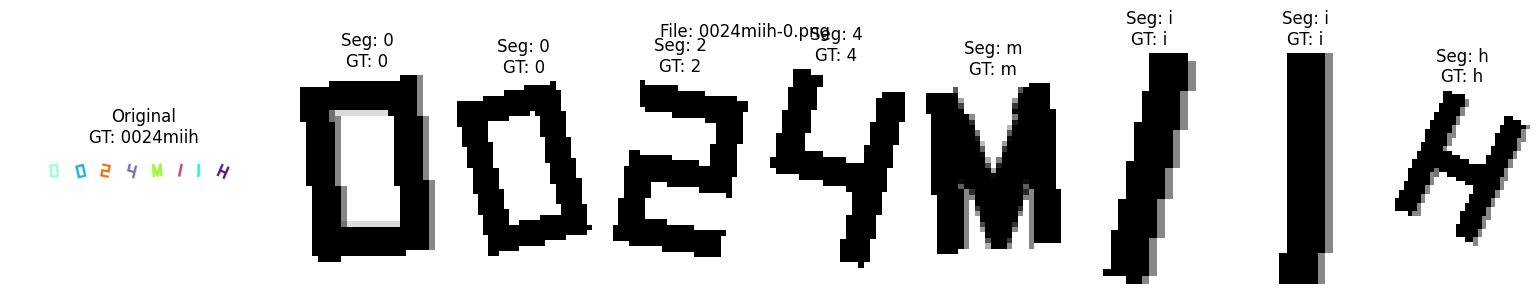

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_17568\3597752500.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


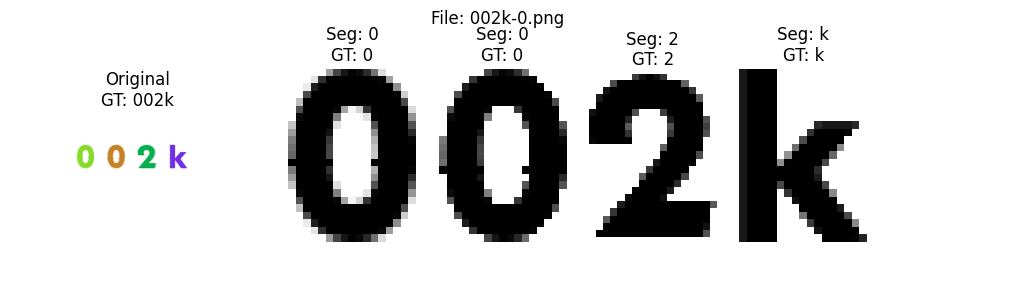

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_17568\3597752500.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


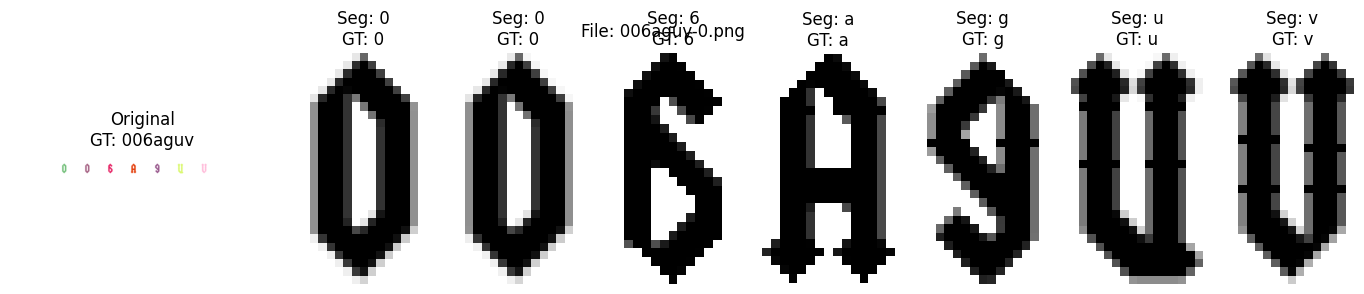

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_17568\3597752500.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


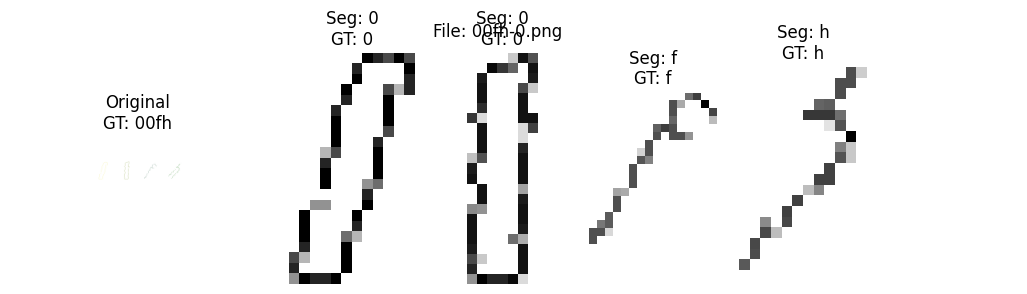

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_17568\3597752500.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


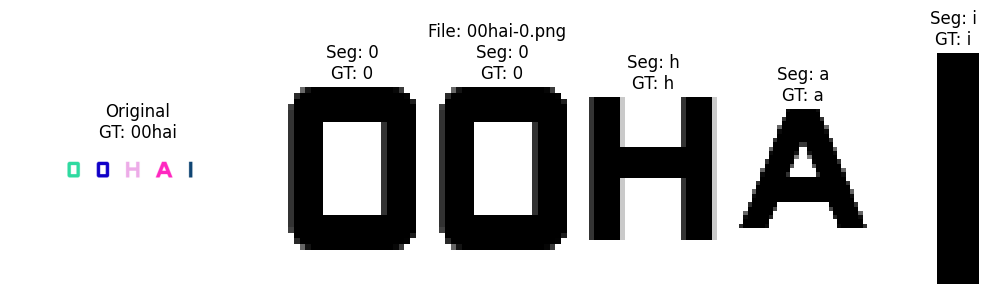

C:\Users\usotsukl\AppData\Local\Temp\ipykernel_17568\3597752500.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


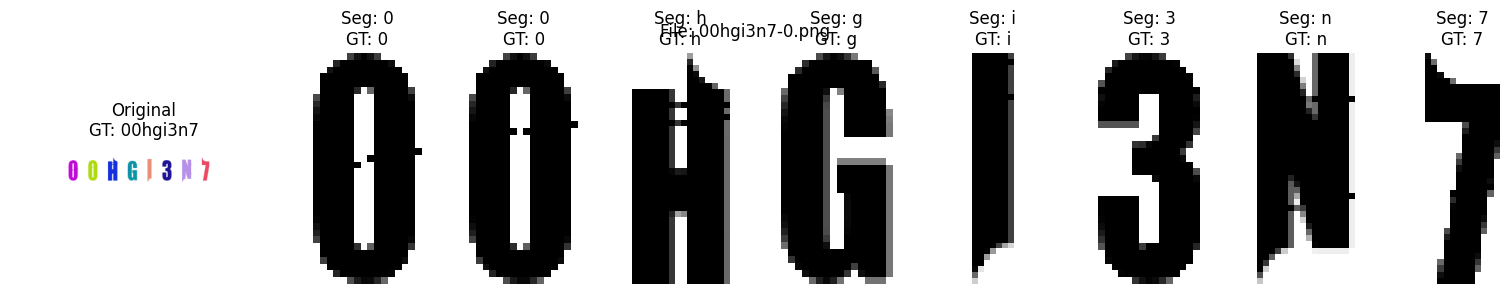

In [8]:
# Visualize original CAPTCHA alongside segmented characters for debugging
from matplotlib.gridspec import GridSpec

n_samples = 6  # how many CAPTCHAs to visualize
samples = train_img_files[:n_samples]

for img_path in samples:
    # Load original
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[WARN] Could not read {img_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Ground truth from filename
    gt_text = Path(img_path).stem.split('-')[0]

    # Segment characters using current pipeline
    char_images, char_labels = segment_characters(img_path)

    # Prepare layout: original on the left, characters on the right
    max_chars = max(len(char_images), len(gt_text)) if len(gt_text) > 0 else len(char_images)
    max_chars = max(5, max_chars)  # keep a minimum width for readability

    fig = plt.figure(figsize=(2 + max_chars * 2.2, 3))
    gs = GridSpec(1, max_chars + 1, width_ratios=[2] + [1] * max_chars, wspace=0.15)

    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_rgb)
    ax0.set_title(f"Original\nGT: {gt_text}")
    ax0.axis('off')

    # Segmented characters
    for j in range(max_chars):
        ax = fig.add_subplot(gs[0, j + 1])
        if j < len(char_images):
            ch_img = char_images[j]
            # robust grayscale for display
            if ch_img is None or ch_img.size == 0:
                ax.axis('off')
                continue
            if len(ch_img.shape) == 3:
                show_img = cv2.cvtColor(ch_img, cv2.COLOR_BGR2GRAY)
            else:
                show_img = ch_img

            # predicted label from segmentation alignment (label list) if available
            seg_label = char_labels[j] if j < len(char_labels) else '?'
            # expected char at this position (from GT) if available
            gt_char = gt_text[j] if j < len(gt_text) else ' '
            title = f"Seg: {seg_label}\nGT: {gt_char}"

            ax.imshow(show_img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(f"File: {Path(img_path).name}")
    plt.tight_layout()
    plt.show()

## 6. Character Recognition Model

CNN-based model for recognizing individual characters.

In [ ]:
import torch
import torch.nn as nn

class InvertedResidualBlock(nn.Module):
    """
    MobileNetV2-style block with depthwise separable convs.
    Supports tuple stride like (2,1) to only downsample height.
    """
    def __init__(self, in_ch, out_ch, stride=1, expand_ratio=6):
        super().__init__()
        if isinstance(stride, int):
            stride = (stride, stride)
        hidden_ch = int(round(in_ch * expand_ratio))
        self.use_residual = (stride == (1, 1) and in_ch == out_ch)

        layers = []
        # 1x1 expand
        if expand_ratio != 1:
            layers += [
                nn.Conv2d(in_ch, hidden_ch, 1, bias=False),
                nn.BatchNorm2d(hidden_ch),
                nn.ReLU6(inplace=True),
            ]
        else:
            hidden_ch = in_ch

        # 3x3 depthwise
        layers += [
            nn.Conv2d(hidden_ch, hidden_ch, 3, stride=stride, padding=1,
                      groups=hidden_ch, bias=False),
            nn.BatchNorm2d(hidden_ch),
            nn.ReLU6(inplace=True),
        ]
        # 1x1 project
        layers += [
            nn.Conv2d(hidden_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        if self.use_residual:
            out = x + out
        return out


class EfficientCRNN_MV2(nn.Module):
    """
    MobileNetV2-style CNN (higher or equal complexity than baseline) + 1-layer BiLSTM + CTC head.
    Downsampling: (2,2) -> (2,2) -> (2,1) -> (2,1), so H: 64->32->16->8->4
    """
    def __init__(self, num_classes, img_height=64,
                 width_mult=1.0, expand_ratio=6,
                 repeats=(2, 2, 3, 2),   # per stage IRB repeats to raise complexity
                 lstm_hidden=128):
        super().__init__()
        self.num_classes = num_classes
        assert img_height == 64, "This config assumes input H=64 for H->4. If different, adjust strides."

        def C(c):  # width multiplier helper
            return int(round(c * width_mult))

        # Stem (比 baseline 更大)
        stem_out = C(64)
        self.stem = nn.Sequential(
            nn.Conv2d(3, stem_out, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(stem_out),
            nn.ReLU6(inplace=True),
        )

        # Stage channels（最终到 256，与 baseline 一致甚至更强）
        c1, c2, c3, c4 = C(128), C(192), C(256), C(256)

        blocks = []

        # Stage 1: H,W /2  (stride=(2,2))
        blocks += [InvertedResidualBlock(stem_out, c1, stride=(2, 2), expand_ratio=expand_ratio)]
        for _ in range(repeats[0]-1):
            blocks += [InvertedResidualBlock(c1, c1, stride=1, expand_ratio=expand_ratio)]

        # Stage 2: H,W /2 again  (stride=(2,2)) -> total H:64->16, W:W->W/4
        blocks += [InvertedResidualBlock(c1, c2, stride=(2, 2), expand_ratio=expand_ratio)]
        for _ in range(repeats[1]-1):
            blocks += [InvertedResidualBlock(c2, c2, stride=1, expand_ratio=expand_ratio)]

        # Stage 3: only downsample height  (stride=(2,1)) -> H:16->8
        blocks += [InvertedResidualBlock(c2, c3, stride=(2, 1), expand_ratio=expand_ratio)]
        for _ in range(repeats[2]-1):
            blocks += [InvertedResidualBlock(c3, c3, stride=1, expand_ratio=expand_ratio)]

        # Stage 4: only downsample height  (stride=(2,1)) -> H:8->4 ; keep W
        blocks += [InvertedResidualBlock(c3, c4, stride=(2, 1), expand_ratio=expand_ratio)]
        for _ in range(repeats[3]-1):
            blocks += [InvertedResidualBlock(c4, c4, stride=1, expand_ratio=expand_ratio)]

        self.cnn = nn.Sequential(*blocks)

        # 最终特征形状约 [B, C4(≈256*wm), H=4, W/4]
        self.rnn_input_size = c4 * 4  # concatenate channel*height along feature dim

        # 轻量 BiLSTM（可把 hidden 提到 192/256 提升表达）
        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=lstm_hidden,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.0
        )
        self.fc = nn.Linear(lstm_hidden * 2, num_classes + 1)  # +1 for CTC blank

    def forward(self, x):
        x = self.stem(x)     # [B, Cs, 64,  W]
        feat = self.cnn(x)   # [B, C4,  4,  W/4]

        B, C, H, W = feat.size()
        seq = feat.permute(0, 3, 1, 2).contiguous().view(B, W, C * H)  # [B, T=W, C*H]
        rnn_out, _ = self.rnn(seq)                                     # [B, T, 2*hidden]
        logits = self.fc(rnn_out)                                      # [B, T, classes+1]
        return logits.permute(1, 0, 2)                                 # [T, B, classes+1]


In [ ]:
# Initialize model with matching image height
IMG_HEIGHT = 64  # Must match dataset target_size height

model = EfficientCRNN_MV2(
    num_classes=VOCAB_SIZE,
    img_height=IMG_HEIGHT,
    width_mult=1.0,
    expand_ratio=6,
    repeats=(2, 2, 3, 2),
    lstm_hidden=128
).to(device)

print(f"Model initialized on device: {device}")
print(f"Input image size: {IMG_HEIGHT}x{IMG_HEIGHT}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

## 7. Create DataLoaders

In [25]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm issues
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
    # No drop_last for test - we use model.eval() which disables BatchNorm training mode
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1463
Test batches: 376


## 8. Training Setup

In [26]:
# Training hyperparameters
NUM_EPOCHS = 20
BASE_LR = 3e-3
MAX_LR = 1e-2
WEIGHT_DECAY = 1e-4

# Loss and optimizer (label smoothing helps robustness)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

# OneCycleLR for fast convergence with higher LR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0,
)

## 9. Training Loop

In [29]:
def train_epoch(model, loader, criterion, optimizer, device, scheduler=None, max_grad_norm=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for imgs, labels, _ in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        if max_grad_norm is not None and max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        # Scheduler step per batch (OneCycle)
        if scheduler is not None:
            scheduler.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(loader), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [28]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scheduler=scheduler)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print summary
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_char_recognition_model.pth')
        print(f"✓ New best model saved! Accuracy: {best_acc:.2f}%")

print(f"\nTraining complete! Best accuracy: {best_acc:.2f}%")


Epoch 1/20


Training:   0%|          | 0/1463 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 1024, got 512

## 10. Visualize Training History

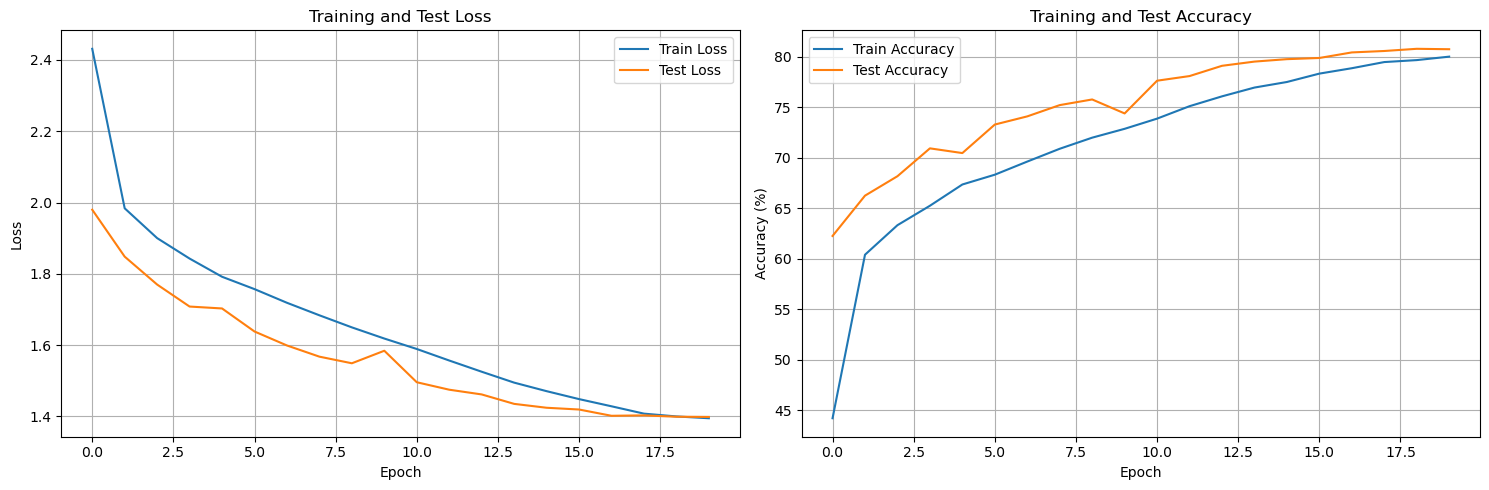

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Full CAPTCHA Recognition

Combine segmentation + recognition to decode complete CAPTCHAs.

In [ ]:
def recognize_captcha(model, image_path, device, target_size=(64, 64)):
    """
    Recognize a full CAPTCHA by:
    1. Segmenting characters
    2. Recognizing each character with the CRNN model
    3. Combining predictions
    """
    model.eval()
    
    # Segment characters
    char_images, _ = segment_characters(image_path)
    
    if not char_images:
        return "", []
    
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for char_img in char_images:
            # Preprocess
            if len(char_img.shape) == 3:
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
            
            h, w = char_img.shape
            target_h, target_w = target_size
            
            # Check for invalid dimensions
            if h <= 0 or w <= 0:
                continue  # Skip invalid images
            
            scale = min(target_h / h, target_w / w)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Ensure minimum size of 1x1
            new_h = max(1, new_h)
            new_w = max(1, new_w)
            
            char_img = cv2.resize(char_img, (new_w, new_h))
            
            canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
            y_offset = (target_h - new_h) // 2
            x_offset = (target_w - new_w) // 2
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
            
            # Convert to tensor
            char_tensor = torch.from_numpy(canvas).float() / 255.0
            char_tensor = char_tensor.unsqueeze(0).repeat(3, 1, 1)  # 3 channels
            char_tensor = char_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Predict with CRNN (outputs [T, B, C])
            outputs = model(char_tensor)
            
            # Decode CTC output
            _, preds = outputs.max(2)  # [T, B]
            preds = preds[:, 0]  # Get first (and only) batch item [T]
            
            # Remove blanks and consecutive duplicates
            pred_chars = []
            prev_char = None
            for char_idx in preds:
                char_idx = char_idx.item()
                if char_idx != VOCAB_SIZE and char_idx != prev_char:
                    pred_chars.append(char_idx)
                prev_char = char_idx
            
            # Take the most confident prediction (first non-blank character)
            if len(pred_chars) > 0:
                pred_idx = pred_chars[0]
                pred_char = id2ch[pred_idx]
                predictions.append(pred_char)
                
                # Calculate confidence from softmax probabilities
                probs = F.softmax(outputs, dim=2)  # [T, B, C]
                max_prob = probs[:, 0, pred_idx].max().item()
                confidences.append(max_prob)
    
    result = ''.join(predictions)
    return result, confidences


def visualize_captcha_prediction(image_path, model, device):
    """
    Visualize CAPTCHA recognition result
    """
    # Get ground truth
    filename = Path(image_path).stem
    gt_text = filename.split('-')[0]
    
    # Predict
    pred_text, confidences = recognize_captcha(model, image_path, device)
    
    # Load and display image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(img_rgb)
    if len(confidences) > 0:
        plt.title(f"Ground Truth: {gt_text}\nPrediction: {pred_text}\nConfidence: {np.mean(confidences):.3f}")
    else:
        plt.title(f"Ground Truth: {gt_text}\nPrediction: {pred_text}\nNo predictions")
    plt.axis('off')
    plt.show()
    
    return gt_text, pred_text

## 12. Test on Sample CAPTCHAs

/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/1386466849.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_char_r

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


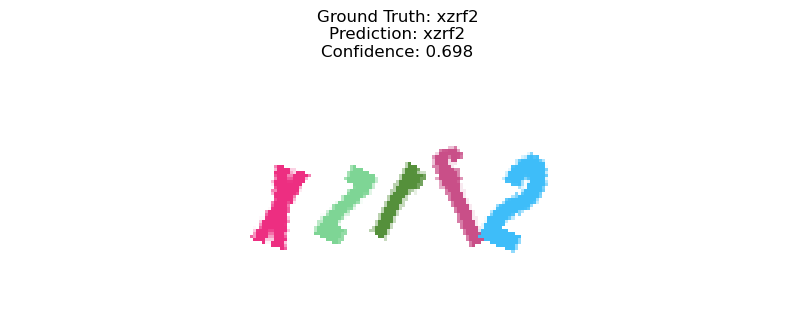

✓ Correct!

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).


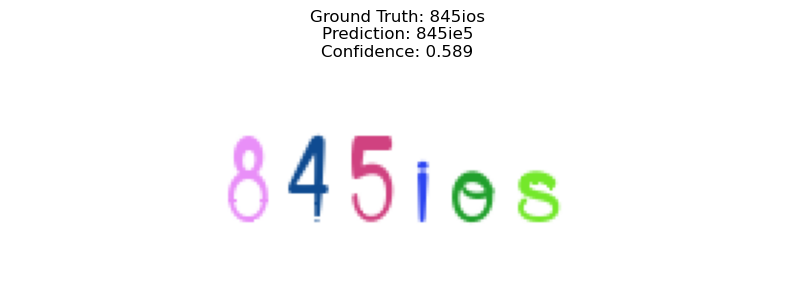

✗ Wrong. GT: 845ios, Pred: 845ie5

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


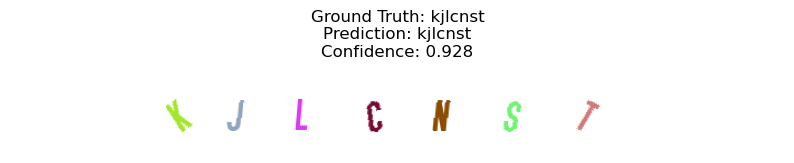

✓ Correct!

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


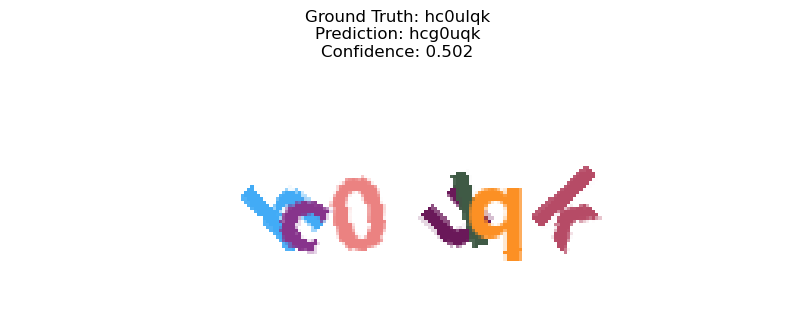

✗ Wrong. GT: hc0ulqk, Pred: hcg0uqk

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).


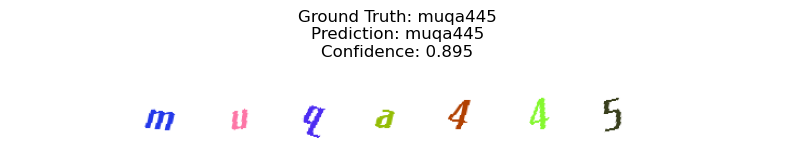

✓ Correct!


Accuracy: 3/5 = 60.00%


In [42]:
# Load best model
model.load_state_dict(torch.load('best_char_recognition_model.pth'))
model.eval()

# Test on a few samples
test_samples = test_img_files[:5]

correct = 0
total = len(test_samples)

for img_path in test_samples:
    gt, pred = visualize_captcha_prediction(img_path, model, device)
    if gt == pred:
        correct += 1
        print(f"✓ Correct!\n")
    else:
        print(f"✗ Wrong. GT: {gt}, Pred: {pred}\n")

print(f"\nAccuracy: {correct}/{total} = {100*correct/total:.2f}%")

## 13. Full Test Set Evaluation

In [46]:
def evaluate_full_captchas(model, img_paths, device):
    """
    Evaluate on full CAPTCHA images
    """
    model.eval()
    
    total = 0
    correct = 0
    char_total = 0
    char_correct = 0
    
    for img_path in tqdm(img_paths, desc="Evaluating CAPTCHAs"):
        try:
            filename = Path(img_path).stem
            gt_text = filename.split('-')[0].lower()
            
            pred_text, _ = recognize_captcha(model, img_path, device)
            pred_text = pred_text.lower()
            
            total += 1
            if gt_text == pred_text:
                correct += 1
            
            # Character-level accuracy
            for gt_ch, pred_ch in zip(gt_text, pred_text):
                char_total += 1
                if gt_ch == pred_ch:
                    char_correct += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    seq_acc = 100 * correct / total if total > 0 else 0
    char_acc = 100 * char_correct / char_total if char_total > 0 else 0
    
    print(f"\nResults on {total} CAPTCHAs:")
    print(f"Sequence Accuracy: {seq_acc:.2f}% ({correct}/{total})")
    print(f"Character Accuracy: {char_acc:.2f}% ({char_correct}/{char_total})")
    
    return seq_acc, char_acc


# Evaluate on test set
test_seq_acc, test_char_acc = evaluate_full_captchas(model, test_img_files, device)

Evaluating CAPTCHAs:   0%|          | 0/2000 [00:00<?, ?it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:   0%|          | 3/2000 [00:00<03:47,  8.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 7/2000 [00:00<02:38, 12.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 9/2000 [00:00<02:45, 12.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:   1%|          | 11/2000 [00:01<02:49, 11.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:   1%|          | 15/2000 [00:01<02:25, 13.66it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 161).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:   1%|          | 17/2000 [00:01<02:47, 11.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 21/2000 [00:01<02:29, 13.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 23/2000 [00:01<02:34, 12.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 25/2000 [00:02<02:33, 12.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 27/2000 [00:02<02:49, 11.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:   2%|▏         | 31/2000 [00:02<02:44, 11.94it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:   2%|▏         | 35/2000 [00:02<02:30, 13.06it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 37/2000 [00:03<02:23, 13.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:   2%|▏         | 39/2000 [00:03<02:39, 12.26it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 76).


Evaluating CAPTCHAs:   2%|▏         | 43/2000 [00:03<02:40, 12.17it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 45/2000 [00:03<02:34, 12.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 49/2000 [00:04<02:30, 12.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 51/2000 [00:04<02:32, 12.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   3%|▎         | 55/2000 [00:04<02:19, 13.97it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 57/2000 [00:04<02:21, 13.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:   3%|▎         | 59/2000 [00:04<02:26, 13.24it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:   3%|▎         | 63/2000 [00:05<02:18, 13.99it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 67/2000 [00:05<02:18, 13.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 69/2000 [00:05<02:11, 14.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 73/2000 [00:05<02:04, 15.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:   4%|▍         | 75/2000 [00:05<02:02, 15.68it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   4%|▍         | 80/2000 [00:06<02:01, 15.77it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:   4%|▍         | 82/2000 [00:06<02:00, 15.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:   4%|▍         | 84/2000 [00:06<01:59, 15.99it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 88/2000 [00:06<02:38, 12.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 90/2000 [00:06<02:24, 13.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:   5%|▍         | 94/2000 [00:07<02:41, 11.79it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:   5%|▍         | 99/2000 [00:07<02:04, 15.30it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 101/2000 [00:07<02:05, 15.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:   5%|▌         | 105/2000 [00:07<02:00, 15.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:   5%|▌         | 109/2000 [00:08<02:13, 14.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 111/2000 [00:08<02:12, 14.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:   6%|▌         | 115/2000 [00:08<02:19, 13.49it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:   6%|▌         | 117/2000 [00:08<02:24, 13.04it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:   6%|▌         | 121/2000 [00:09<02:46, 11.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 125/2000 [00:09<02:18, 13.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:   6%|▋         | 129/2000 [00:09<02:08, 14.51it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 131/2000 [00:09<02:03, 15.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:   7%|▋         | 136/2000 [00:10<01:47, 17.35it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 140/2000 [00:10<01:47, 17.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:   7%|▋         | 145/2000 [00:10<01:39, 18.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 147/2000 [00:10<01:40, 18.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:   8%|▊         | 152/2000 [00:11<01:51, 16.64it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 154/2000 [00:11<01:59, 15.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:   8%|▊         | 156/2000 [00:11<02:35, 11.83it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 158/2000 [00:11<02:35, 11.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 162/2000 [00:12<02:25, 12.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 165/2000 [00:12<02:03, 14.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 169/2000 [00:12<02:02, 14.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:   9%|▊         | 173/2000 [00:12<01:58, 15.42it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 177/2000 [00:12<01:50, 16.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 179/2000 [00:13<01:49, 16.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   9%|▉         | 184/2000 [00:13<01:45, 17.22it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:   9%|▉         | 189/2000 [00:13<01:42, 17.65it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 191/2000 [00:13<01:41, 17.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).


Evaluating CAPTCHAs:  10%|▉         | 195/2000 [00:14<01:55, 15.68it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 199/2000 [00:14<01:56, 15.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 201/2000 [00:14<01:55, 15.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  10%|█         | 206/2000 [00:14<01:39, 17.97it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  10%|█         | 210/2000 [00:14<01:46, 16.80it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 212/2000 [00:15<02:16, 13.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  11%|█         | 217/2000 [00:15<01:55, 15.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 97).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  11%|█         | 221/2000 [00:15<02:00, 14.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 223/2000 [00:15<02:05, 14.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  11%|█▏        | 225/2000 [00:16<02:07, 13.95it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).


Evaluating CAPTCHAs:  12%|█▏        | 230/2000 [00:16<02:02, 14.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 232/2000 [00:16<01:59, 14.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  12%|█▏        | 236/2000 [00:16<01:51, 15.88it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  12%|█▏        | 240/2000 [00:16<01:49, 16.11it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 244/2000 [00:17<02:01, 14.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 135).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 247/2000 [00:17<01:46, 16.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 251/2000 [00:17<01:45, 16.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  13%|█▎        | 256/2000 [00:17<01:35, 18.25it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 259/2000 [00:18<01:27, 19.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  13%|█▎        | 261/2000 [00:18<01:43, 16.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  13%|█▎        | 265/2000 [00:18<01:51, 15.52it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 269/2000 [00:18<01:55, 15.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▎        | 271/2000 [00:18<01:51, 15.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 125).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  14%|█▍        | 276/2000 [00:19<01:47, 16.01it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 123).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).


Evaluating CAPTCHAs:  14%|█▍        | 278/2000 [00:19<01:54, 15.06it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).


Evaluating CAPTCHAs:  14%|█▍        | 282/2000 [00:19<01:51, 15.41it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  14%|█▍        | 285/2000 [00:19<01:42, 16.71it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  14%|█▍        | 289/2000 [00:19<01:45, 16.17it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:  15%|█▍        | 292/2000 [00:20<01:39, 17.19it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  15%|█▍        | 297/2000 [00:20<01:34, 17.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 302/2000 [00:20<01:32, 18.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  15%|█▌        | 306/2000 [00:20<01:35, 17.71it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 309/2000 [00:21<01:29, 18.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:  16%|█▌        | 313/2000 [00:21<01:39, 16.90it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  16%|█▌        | 315/2000 [00:21<01:41, 16.59it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  16%|█▌        | 319/2000 [00:21<01:38, 17.12it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  16%|█▌        | 323/2000 [00:21<01:42, 16.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 328/2000 [00:22<01:35, 17.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 123).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 330/2000 [00:22<01:35, 17.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  17%|█▋        | 334/2000 [00:22<01:41, 16.41it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  17%|█▋        | 338/2000 [00:22<01:46, 15.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  17%|█▋        | 340/2000 [00:22<01:46, 15.60it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  17%|█▋        | 344/2000 [00:23<01:52, 14.68it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  17%|█▋        | 348/2000 [00:23<01:50, 15.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 351/2000 [00:23<01:47, 15.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  18%|█▊        | 353/2000 [00:23<01:52, 14.61it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  18%|█▊        | 357/2000 [00:24<01:56, 14.14it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  18%|█▊        | 359/2000 [00:24<01:56, 14.11it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  18%|█▊        | 363/2000 [00:24<01:58, 13.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 367/2000 [00:24<01:48, 15.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  18%|█▊        | 369/2000 [00:24<01:48, 15.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  19%|█▊        | 373/2000 [00:25<01:42, 15.88it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  19%|█▉        | 377/2000 [00:25<01:40, 16.18it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  19%|█▉        | 379/2000 [00:25<01:47, 15.08it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).


Evaluating CAPTCHAs:  19%|█▉        | 383/2000 [00:25<01:50, 14.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  19%|█▉        | 387/2000 [00:26<01:50, 14.56it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 390/2000 [00:26<01:41, 15.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 394/2000 [00:26<01:41, 15.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 396/2000 [00:26<01:43, 15.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  20%|██        | 400/2000 [00:26<01:37, 16.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  20%|██        | 404/2000 [00:27<01:37, 16.37it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 408/2000 [00:27<01:40, 15.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  21%|██        | 412/2000 [00:27<01:44, 15.24it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 414/2000 [00:27<01:47, 14.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 418/2000 [00:28<01:44, 15.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  21%|██        | 422/2000 [00:28<01:40, 15.72it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  21%|██▏       | 427/2000 [00:28<01:29, 17.56it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 429/2000 [00:28<01:32, 16.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 433/2000 [00:29<01:42, 15.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 435/2000 [00:29<01:44, 15.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 439/2000 [00:29<01:40, 15.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  22%|██▏       | 443/2000 [00:29<01:40, 15.56it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 445/2000 [00:29<01:38, 15.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  22%|██▏       | 449/2000 [00:30<01:40, 15.41it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  23%|██▎       | 454/2000 [00:30<01:31, 16.82it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  23%|██▎       | 458/2000 [00:30<01:36, 15.99it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 461/2000 [00:30<01:29, 17.18it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  23%|██▎       | 465/2000 [00:31<01:32, 16.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  23%|██▎       | 469/2000 [00:31<01:32, 16.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▎       | 472/2000 [00:31<01:22, 18.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 476/2000 [00:31<01:32, 16.49it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  24%|██▍       | 480/2000 [00:31<01:31, 16.58it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 482/2000 [00:32<01:35, 15.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 487/2000 [00:32<01:29, 16.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 106).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 490/2000 [00:32<01:24, 17.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  25%|██▍       | 494/2000 [00:32<01:31, 16.53it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 496/2000 [00:32<01:38, 15.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 500/2000 [00:33<01:30, 16.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  25%|██▌       | 504/2000 [00:33<01:33, 16.08it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  25%|██▌       | 507/2000 [00:33<01:32, 16.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 511/2000 [00:33<01:36, 15.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 513/2000 [00:33<01:32, 16.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  26%|██▌       | 517/2000 [00:34<01:33, 15.78it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 521/2000 [00:34<01:24, 17.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 525/2000 [00:34<01:23, 17.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  26%|██▋       | 529/2000 [00:34<01:32, 15.82it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 531/2000 [00:35<01:32, 15.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 535/2000 [00:35<01:41, 14.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 537/2000 [00:35<01:52, 13.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  27%|██▋       | 541/2000 [00:35<01:37, 15.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  27%|██▋       | 543/2000 [00:35<01:41, 14.38it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  27%|██▋       | 547/2000 [00:36<01:36, 15.06it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  28%|██▊       | 551/2000 [00:36<01:33, 15.51it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  28%|██▊       | 553/2000 [00:36<01:35, 15.18it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  28%|██▊       | 558/2000 [00:36<01:22, 17.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 562/2000 [00:37<01:31, 15.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 564/2000 [00:37<01:36, 14.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 153).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  28%|██▊       | 568/2000 [00:37<01:37, 14.72it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 570/2000 [00:37<02:03, 11.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▊       | 574/2000 [00:38<01:48, 13.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 578/2000 [00:38<01:31, 15.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 581/2000 [00:38<01:20, 17.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 586/2000 [00:38<01:18, 17.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 588/2000 [00:38<01:18, 18.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  30%|██▉       | 592/2000 [00:39<01:26, 16.25it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 596/2000 [00:39<01:23, 16.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 598/2000 [00:39<01:29, 15.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  30%|███       | 602/2000 [00:39<01:25, 16.26it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 604/2000 [00:39<01:32, 15.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  30%|███       | 608/2000 [00:40<01:39, 13.97it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  31%|███       | 612/2000 [00:40<01:31, 15.17it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  31%|███       | 616/2000 [00:40<01:29, 15.42it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 618/2000 [00:40<01:28, 15.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  31%|███       | 622/2000 [00:41<01:30, 15.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  31%|███       | 624/2000 [00:41<01:32, 14.85it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  31%|███▏      | 628/2000 [00:41<01:34, 14.49it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  32%|███▏      | 630/2000 [00:41<01:35, 14.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  32%|███▏      | 634/2000 [00:41<01:31, 14.92it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  32%|███▏      | 638/2000 [00:42<01:28, 15.35it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  32%|███▏      | 642/2000 [00:42<01:24, 16.13it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  32%|███▏      | 645/2000 [00:42<01:19, 17.02it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  32%|███▏      | 649/2000 [00:42<01:21, 16.67it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 654/2000 [00:42<01:10, 19.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  33%|███▎      | 658/2000 [00:43<01:16, 17.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 660/2000 [00:43<01:19, 16.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  33%|███▎      | 664/2000 [00:43<01:20, 16.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  33%|███▎      | 668/2000 [00:43<01:18, 16.90it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  34%|███▎      | 673/2000 [00:44<01:16, 17.24it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 675/2000 [00:44<01:22, 16.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  34%|███▍      | 679/2000 [00:44<01:17, 17.05it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  34%|███▍      | 682/2000 [00:44<01:13, 17.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 223).


Evaluating CAPTCHAs:  34%|███▍      | 686/2000 [00:44<01:22, 15.85it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 691/2000 [00:45<01:14, 17.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 693/2000 [00:45<01:20, 16.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  35%|███▍      | 697/2000 [00:45<01:21, 15.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 701/2000 [00:45<01:24, 15.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  35%|███▌      | 705/2000 [00:46<01:20, 16.04it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 707/2000 [00:46<01:22, 15.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  36%|███▌      | 711/2000 [00:46<01:23, 15.50it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  36%|███▌      | 715/2000 [00:46<01:21, 15.78it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 115).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 717/2000 [00:46<01:23, 15.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).


Evaluating CAPTCHAs:  36%|███▌      | 721/2000 [00:47<01:15, 17.04it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 725/2000 [00:47<01:19, 15.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  36%|███▋      | 729/2000 [00:47<01:17, 16.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  37%|███▋      | 733/2000 [00:47<01:15, 16.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 737/2000 [00:48<01:10, 17.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 740/2000 [00:48<01:07, 18.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 70).


Evaluating CAPTCHAs:  37%|███▋      | 745/2000 [00:48<01:07, 18.49it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  38%|███▊      | 750/2000 [00:48<01:04, 19.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 752/2000 [00:48<01:06, 18.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 149).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  38%|███▊      | 756/2000 [00:49<01:23, 14.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 759/2000 [00:49<01:18, 15.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  38%|███▊      | 764/2000 [00:49<01:11, 17.18it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 766/2000 [00:49<01:12, 17.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  38%|███▊      | 770/2000 [00:49<01:14, 16.56it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▊      | 774/2000 [00:50<01:08, 17.82it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 778/2000 [00:50<01:07, 18.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  39%|███▉      | 782/2000 [00:50<01:14, 16.42it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:  39%|███▉      | 785/2000 [00:50<01:07, 17.97it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:  39%|███▉      | 789/2000 [00:51<01:12, 16.72it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  40%|███▉      | 793/2000 [00:51<01:10, 17.01it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  40%|███▉      | 797/2000 [00:51<01:11, 16.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 799/2000 [00:51<01:10, 17.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  40%|████      | 803/2000 [00:51<01:13, 16.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 808/2000 [00:52<01:09, 17.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  41%|████      | 812/2000 [00:52<01:13, 16.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 814/2000 [00:52<01:15, 15.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  41%|████      | 816/2000 [00:52<01:18, 15.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  41%|████      | 821/2000 [00:53<01:13, 15.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  41%|████▏     | 825/2000 [00:53<01:11, 16.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  41%|████▏     | 827/2000 [00:53<01:09, 16.86it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  42%|████▏     | 832/2000 [00:53<01:10, 16.51it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  42%|████▏     | 834/2000 [00:53<01:13, 15.83it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  42%|████▏     | 838/2000 [00:54<01:23, 13.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  42%|████▏     | 840/2000 [00:54<01:23, 13.83it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  42%|████▏     | 844/2000 [00:54<01:20, 14.32it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 848/2000 [00:54<01:20, 14.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▎     | 850/2000 [00:55<01:22, 13.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  43%|████▎     | 855/2000 [00:55<01:10, 16.15it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  43%|████▎     | 859/2000 [00:55<01:11, 15.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 862/2000 [00:55<01:05, 17.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 866/2000 [00:55<01:10, 16.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  44%|████▎     | 871/2000 [00:56<01:01, 18.51it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  44%|████▎     | 874/2000 [00:56<00:58, 19.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  44%|████▍     | 878/2000 [00:56<01:07, 16.67it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 134).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 882/2000 [00:56<01:09, 15.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 884/2000 [00:56<01:09, 16.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 888/2000 [00:57<01:12, 15.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  44%|████▍     | 890/2000 [00:57<01:09, 15.91it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  45%|████▍     | 894/2000 [00:57<01:12, 15.33it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 899/2000 [00:57<01:06, 16.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 901/2000 [00:58<01:06, 16.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  45%|████▌     | 906/2000 [00:58<01:04, 16.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).


Evaluating CAPTCHAs:  46%|████▌     | 910/2000 [00:58<01:07, 16.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 912/2000 [00:58<01:09, 15.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  46%|████▌     | 916/2000 [00:59<01:06, 16.41it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 920/2000 [00:59<01:06, 16.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 924/2000 [00:59<01:05, 16.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 928/2000 [00:59<01:02, 17.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 140).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 930/2000 [00:59<01:07, 15.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  47%|████▋     | 935/2000 [01:00<01:02, 16.97it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 937/2000 [01:00<01:07, 15.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 941/2000 [01:00<01:08, 15.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  47%|████▋     | 944/2000 [01:00<01:03, 16.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 139).


Evaluating CAPTCHAs:  47%|████▋     | 948/2000 [01:01<01:11, 14.64it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  48%|████▊     | 952/2000 [01:01<01:07, 15.43it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 956/2000 [01:01<01:01, 16.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 958/2000 [01:01<00:58, 17.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  48%|████▊     | 963/2000 [01:01<00:56, 18.24it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 100).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:  48%|████▊     | 965/2000 [01:02<01:03, 16.31it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  49%|████▊     | 971/2000 [01:02<00:53, 19.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 976/2000 [01:02<00:55, 18.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  49%|████▉     | 978/2000 [01:02<01:00, 16.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  49%|████▉     | 983/2000 [01:02<00:55, 18.20it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 986/2000 [01:03<00:54, 18.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  50%|████▉     | 990/2000 [01:03<01:05, 15.43it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  50%|████▉     | 994/2000 [01:03<01:01, 16.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  50%|████▉     | 997/2000 [01:03<00:59, 16.88it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1001/2000 [01:04<01:01, 16.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  50%|█████     | 1005/2000 [01:04<01:00, 16.51it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1007/2000 [01:04<01:00, 16.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  51%|█████     | 1011/2000 [01:04<01:01, 16.03it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1015/2000 [01:04<01:00, 16.19it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  51%|█████     | 1019/2000 [01:05<00:57, 16.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  51%|█████     | 1023/2000 [01:05<00:59, 16.39it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████▏    | 1025/2000 [01:05<01:05, 14.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1030/2000 [01:05<00:55, 17.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  52%|█████▏    | 1033/2000 [01:06<00:48, 19.74it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 166).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1039/2000 [01:06<00:50, 18.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1042/2000 [01:06<00:51, 18.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1044/2000 [01:06<00:53, 17.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  52%|█████▏    | 1048/2000 [01:06<01:00, 15.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1053/2000 [01:07<00:52, 18.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 192).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  53%|█████▎    | 1057/2000 [01:07<00:54, 17.18it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1060/2000 [01:07<00:51, 18.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  53%|█████▎    | 1064/2000 [01:07<00:50, 18.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  53%|█████▎    | 1069/2000 [01:08<00:51, 18.03it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▎    | 1071/2000 [01:08<00:55, 16.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  54%|█████▍    | 1075/2000 [01:08<00:56, 16.26it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  54%|█████▍    | 1079/2000 [01:08<00:58, 15.65it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  54%|█████▍    | 1082/2000 [01:08<00:55, 16.67it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1086/2000 [01:09<00:55, 16.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  55%|█████▍    | 1090/2000 [01:09<00:56, 16.10it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1093/2000 [01:09<00:50, 18.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  55%|█████▍    | 1097/2000 [01:09<00:51, 17.37it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).


Evaluating CAPTCHAs:  55%|█████▌    | 1100/2000 [01:09<00:53, 16.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  55%|█████▌    | 1105/2000 [01:10<00:49, 18.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  55%|█████▌    | 1107/2000 [01:10<00:54, 16.28it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 197).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  56%|█████▌    | 1113/2000 [01:10<00:47, 18.87it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1118/2000 [01:10<00:47, 18.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1122/2000 [01:11<00:50, 17.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1125/2000 [01:11<00:46, 18.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1130/2000 [01:11<00:47, 18.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1132/2000 [01:11<00:47, 18.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  57%|█████▋    | 1136/2000 [01:11<00:49, 17.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1140/2000 [01:12<00:52, 16.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  57%|█████▋    | 1142/2000 [01:12<00:51, 16.76it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  57%|█████▋    | 1146/2000 [01:12<00:53, 15.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  57%|█████▊    | 1150/2000 [01:12<00:54, 15.67it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1152/2000 [01:12<00:52, 16.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  58%|█████▊    | 1156/2000 [01:13<01:01, 13.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1158/2000 [01:13<00:55, 15.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  58%|█████▊    | 1162/2000 [01:13<00:54, 15.29it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  58%|█████▊    | 1167/2000 [01:13<00:47, 17.59it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  58%|█████▊    | 1170/2000 [01:14<00:44, 18.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  59%|█████▊    | 1174/2000 [01:14<00:45, 18.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1178/2000 [01:14<00:53, 15.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1180/2000 [01:14<00:51, 16.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  59%|█████▉    | 1184/2000 [01:14<00:53, 15.24it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  59%|█████▉    | 1188/2000 [01:15<00:54, 14.97it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1190/2000 [01:15<00:51, 15.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  60%|█████▉    | 1194/2000 [01:15<00:49, 16.35it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  60%|█████▉    | 1198/2000 [01:15<00:46, 17.09it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1203/2000 [01:16<00:48, 16.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1205/2000 [01:16<00:48, 16.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  60%|██████    | 1210/2000 [01:16<00:45, 17.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  61%|██████    | 1213/2000 [01:16<00:44, 17.67it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  61%|██████    | 1217/2000 [01:16<00:43, 17.80it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  61%|██████    | 1221/2000 [01:17<00:45, 17.10it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████▏   | 1225/2000 [01:17<00:47, 16.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  61%|██████▏   | 1228/2000 [01:17<00:45, 16.92it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  62%|██████▏   | 1231/2000 [01:17<00:45, 17.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  62%|██████▏   | 1235/2000 [01:17<00:47, 16.10it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  62%|██████▏   | 1240/2000 [01:18<00:45, 16.70it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  62%|██████▏   | 1243/2000 [01:18<00:44, 17.16it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1247/2000 [01:18<00:48, 15.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 120).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1249/2000 [01:18<00:49, 15.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  63%|██████▎   | 1253/2000 [01:19<00:46, 16.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  63%|██████▎   | 1257/2000 [01:19<00:44, 16.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  63%|██████▎   | 1261/2000 [01:19<00:40, 18.09it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1266/2000 [01:19<00:41, 17.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1269/2000 [01:19<00:38, 18.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  64%|██████▎   | 1273/2000 [01:20<00:42, 16.99it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1277/2000 [01:20<00:45, 15.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1279/2000 [01:20<00:43, 16.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1284/2000 [01:20<00:45, 15.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1287/2000 [01:21<00:43, 16.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  65%|██████▍   | 1292/2000 [01:21<00:38, 18.41it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1294/2000 [01:21<00:41, 16.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  65%|██████▍   | 1299/2000 [01:21<00:39, 17.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  65%|██████▌   | 1301/2000 [01:21<00:41, 16.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  65%|██████▌   | 1305/2000 [01:22<00:41, 16.63it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▌   | 1309/2000 [01:22<00:43, 15.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  66%|██████▌   | 1313/2000 [01:22<00:40, 17.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  66%|██████▌   | 1317/2000 [01:22<00:38, 17.64it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1321/2000 [01:23<00:38, 17.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1324/2000 [01:23<00:37, 18.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  66%|██████▋   | 1328/2000 [01:23<00:41, 16.19it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1332/2000 [01:23<00:40, 16.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  67%|██████▋   | 1335/2000 [01:23<00:38, 17.11it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1339/2000 [01:24<00:41, 15.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1341/2000 [01:24<00:42, 15.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  67%|██████▋   | 1346/2000 [01:24<00:38, 17.01it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 95).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1350/2000 [01:24<00:39, 16.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  68%|██████▊   | 1354/2000 [01:25<00:40, 15.85it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1356/2000 [01:25<00:43, 14.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).


Evaluating CAPTCHAs:  68%|██████▊   | 1362/2000 [01:25<00:34, 18.29it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1364/2000 [01:25<00:37, 17.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  68%|██████▊   | 1368/2000 [01:25<00:36, 17.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▊   | 1372/2000 [01:26<00:36, 17.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1377/2000 [01:26<00:34, 17.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1379/2000 [01:26<00:36, 16.92it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 141).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1385/2000 [01:26<00:34, 18.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1389/2000 [01:27<00:34, 17.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1393/2000 [01:27<00:33, 18.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1395/2000 [01:27<00:33, 17.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  70%|███████   | 1400/2000 [01:27<00:36, 16.40it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 92).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1402/2000 [01:27<00:38, 15.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  70%|███████   | 1405/2000 [01:28<00:35, 16.83it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  70%|███████   | 1409/2000 [01:28<00:49, 11.96it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1411/2000 [01:28<00:59,  9.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  71%|███████   | 1415/2000 [01:29<00:52, 11.22it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1419/2000 [01:29<00:42, 13.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1423/2000 [01:29<00:38, 14.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  71%|███████▏  | 1425/2000 [01:29<00:36, 15.81it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  71%|███████▏  | 1429/2000 [01:30<00:43, 13.09it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1431/2000 [01:30<00:42, 13.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1433/2000 [01:30<01:05,  8.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  72%|███████▏  | 1435/2000 [01:30<01:00,  9.41it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  72%|███████▏  | 1437/2000 [01:31<00:58,  9.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  72%|███████▏  | 1441/2000 [01:31<00:53, 10.39it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  72%|███████▏  | 1445/2000 [01:31<00:44, 12.56it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  72%|███████▏  | 1447/2000 [01:31<00:41, 13.32it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  73%|███████▎  | 1451/2000 [01:32<00:36, 15.19it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1456/2000 [01:32<00:31, 17.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1460/2000 [01:32<00:32, 16.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1462/2000 [01:32<00:31, 17.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  73%|███████▎  | 1466/2000 [01:32<00:31, 16.71it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1470/2000 [01:33<00:33, 15.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  74%|███████▎  | 1474/2000 [01:33<00:33, 15.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  74%|███████▍  | 1476/2000 [01:33<00:32, 15.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  74%|███████▍  | 1480/2000 [01:33<00:34, 15.21it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1484/2000 [01:34<00:31, 16.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1488/2000 [01:34<00:30, 16.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  74%|███████▍  | 1490/2000 [01:34<00:29, 17.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  75%|███████▍  | 1494/2000 [01:34<00:36, 13.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  75%|███████▍  | 1497/2000 [01:34<00:30, 16.30it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 110).


Evaluating CAPTCHAs:  75%|███████▌  | 1501/2000 [01:35<00:41, 12.15it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1503/2000 [01:35<00:39, 12.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  75%|███████▌  | 1507/2000 [01:35<00:34, 14.30it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:  75%|███████▌  | 1509/2000 [01:35<00:34, 14.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  76%|███████▌  | 1513/2000 [01:36<00:32, 15.17it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  76%|███████▌  | 1515/2000 [01:36<00:31, 15.44it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  76%|███████▌  | 1519/2000 [01:36<00:32, 14.90it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  76%|███████▌  | 1523/2000 [01:36<00:30, 15.49it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  76%|███████▋  | 1525/2000 [01:37<00:41, 11.52it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▋  | 1527/2000 [01:37<00:37, 12.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1532/2000 [01:37<00:32, 14.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1536/2000 [01:37<00:29, 15.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1538/2000 [01:37<00:29, 15.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  77%|███████▋  | 1542/2000 [01:38<00:30, 15.15it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 142).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  77%|███████▋  | 1546/2000 [01:38<00:30, 14.95it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  77%|███████▋  | 1549/2000 [01:38<00:26, 17.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  78%|███████▊  | 1553/2000 [01:38<00:26, 16.69it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1555/2000 [01:38<00:32, 13.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  78%|███████▊  | 1559/2000 [01:39<00:30, 14.36it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  78%|███████▊  | 1563/2000 [01:39<00:40, 10.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  78%|███████▊  | 1565/2000 [01:39<00:39, 10.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  78%|███████▊  | 1569/2000 [01:40<00:34, 12.35it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▊  | 1573/2000 [01:40<00:30, 13.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1575/2000 [01:40<00:29, 14.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  79%|███████▉  | 1579/2000 [01:40<00:26, 15.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1581/2000 [01:41<00:32, 12.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 117).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  79%|███████▉  | 1585/2000 [01:41<00:28, 14.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1589/2000 [01:41<00:27, 14.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 105).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  80%|███████▉  | 1591/2000 [01:41<00:28, 14.34it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  80%|███████▉  | 1596/2000 [01:41<00:25, 15.61it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  80%|████████  | 1600/2000 [01:42<00:26, 15.33it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1602/2000 [01:42<00:24, 16.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  80%|████████  | 1606/2000 [01:42<00:25, 15.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1610/2000 [01:42<00:24, 15.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  81%|████████  | 1614/2000 [01:43<00:23, 16.22it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1617/2000 [01:43<00:20, 18.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 0).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  81%|████████  | 1621/2000 [01:43<00:21, 17.78it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  81%|████████▏ | 1626/2000 [01:43<00:21, 17.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████▏ | 1628/2000 [01:43<00:22, 16.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  82%|████████▏ | 1632/2000 [01:44<00:21, 16.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  82%|████████▏ | 1636/2000 [01:44<00:22, 16.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).


Evaluating CAPTCHAs:  82%|████████▏ | 1640/2000 [01:44<00:22, 16.08it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1642/2000 [01:44<00:21, 16.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  82%|████████▏ | 1647/2000 [01:45<00:21, 16.78it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1651/2000 [01:45<00:19, 17.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 118).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1654/2000 [01:45<00:20, 17.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 123).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1659/2000 [01:45<00:19, 17.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1661/2000 [01:45<00:20, 16.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  83%|████████▎ | 1665/2000 [01:46<00:20, 16.36it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  84%|████████▎ | 1670/2000 [01:46<00:17, 19.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▎ | 1672/2000 [01:46<00:19, 16.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1676/2000 [01:46<00:20, 15.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1678/2000 [01:46<00:21, 14.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  84%|████████▍ | 1682/2000 [01:47<00:19, 15.91it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1687/2000 [01:47<00:18, 16.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1690/2000 [01:47<00:18, 17.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1694/2000 [01:47<00:19, 15.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1697/2000 [01:48<00:17, 16.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1701/2000 [01:48<00:17, 17.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  85%|████████▌ | 1705/2000 [01:48<00:17, 16.44it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1707/2000 [01:48<00:19, 14.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1712/2000 [01:48<00:15, 18.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  86%|████████▌ | 1715/2000 [01:49<00:14, 19.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  86%|████████▌ | 1719/2000 [01:49<00:22, 12.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1721/2000 [01:49<00:20, 13.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1723/2000 [01:49<00:23, 11.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  86%|████████▋ | 1725/2000 [01:50<00:25, 10.97it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1727/2000 [01:50<00:33,  8.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1728/2000 [01:50<00:33,  8.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  87%|████████▋ | 1732/2000 [01:50<00:24, 10.89it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  87%|████████▋ | 1736/2000 [01:51<00:20, 13.14it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1740/2000 [01:51<00:19, 13.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1742/2000 [01:51<00:21, 12.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1746/2000 [01:51<00:17, 14.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  88%|████████▊ | 1750/2000 [01:52<00:15, 16.14it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  88%|████████▊ | 1754/2000 [01:52<00:15, 15.84it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1756/2000 [01:52<00:15, 16.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1758/2000 [01:52<00:17, 14.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  88%|████████▊ | 1763/2000 [01:52<00:15, 15.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  88%|████████▊ | 1768/2000 [01:53<00:13, 17.36it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1770/2000 [01:53<00:14, 16.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▊ | 1774/2000 [01:53<00:13, 16.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  89%|████████▉ | 1776/2000 [01:53<00:14, 15.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  89%|████████▉ | 1780/2000 [01:53<00:13, 15.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1784/2000 [01:54<00:13, 16.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  89%|████████▉ | 1788/2000 [01:54<00:13, 16.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1790/2000 [01:54<00:14, 14.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1792/2000 [01:54<00:13, 15.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  90%|████████▉ | 1797/2000 [01:55<00:12, 16.29it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1801/2000 [01:55<00:12, 15.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1803/2000 [01:55<00:13, 15.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  90%|█████████ | 1807/2000 [01:55<00:12, 14.89it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1809/2000 [01:55<00:13, 14.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1813/2000 [01:56<00:12, 14.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  91%|█████████ | 1816/2000 [01:56<00:11, 16.23it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  91%|█████████ | 1820/2000 [01:56<00:10, 16.76it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  91%|█████████ | 1824/2000 [01:56<00:11, 15.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████▏| 1828/2000 [01:57<00:11, 15.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1830/2000 [01:57<00:10, 15.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  92%|█████████▏| 1834/2000 [01:57<00:10, 16.46it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  92%|█████████▏| 1839/2000 [01:57<00:09, 17.06it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  92%|█████████▏| 1841/2000 [01:57<00:09, 16.72it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  92%|█████████▏| 1846/2000 [01:58<00:09, 16.18it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  92%|█████████▎| 1850/2000 [01:58<00:10, 13.81it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1854/2000 [01:58<00:09, 15.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1856/2000 [01:58<00:09, 14.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1860/2000 [01:59<00:09, 15.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  93%|█████████▎| 1862/2000 [01:59<00:09, 15.03it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  93%|█████████▎| 1866/2000 [01:59<00:08, 15.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  93%|█████████▎| 1869/2000 [01:59<00:08, 16.17it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  94%|█████████▎| 1873/2000 [01:59<00:08, 15.11it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  94%|█████████▍| 1875/2000 [02:00<00:09, 13.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  94%|█████████▍| 1879/2000 [02:00<00:09, 13.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  94%|█████████▍| 1883/2000 [02:00<00:08, 14.55it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1885/2000 [02:00<00:08, 12.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  94%|█████████▍| 1887/2000 [02:01<00:08, 12.83it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1891/2000 [02:01<00:07, 13.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  95%|█████████▍| 1895/2000 [02:01<00:06, 15.37it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  95%|█████████▍| 1899/2000 [02:01<00:06, 15.51it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1901/2000 [02:01<00:06, 14.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1906/2000 [02:02<00:05, 16.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1908/2000 [02:02<00:05, 15.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  96%|█████████▌| 1913/2000 [02:02<00:05, 17.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  96%|█████████▌| 1917/2000 [02:02<00:04, 16.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1919/2000 [02:03<00:05, 15.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  96%|█████████▌| 1923/2000 [02:03<00:05, 15.27it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  96%|█████████▋| 1927/2000 [02:03<00:04, 15.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  97%|█████████▋| 1931/2000 [02:03<00:04, 15.87it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1933/2000 [02:03<00:04, 15.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  97%|█████████▋| 1937/2000 [02:04<00:04, 13.04it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1940/2000 [02:04<00:03, 15.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  97%|█████████▋| 1944/2000 [02:04<00:03, 14.85it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  97%|█████████▋| 1948/2000 [02:04<00:03, 15.51it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1950/2000 [02:05<00:03, 14.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  98%|█████████▊| 1954/2000 [02:05<00:03, 14.12it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  98%|█████████▊| 1957/2000 [02:05<00:02, 15.53it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  98%|█████████▊| 1960/2000 [02:05<00:02, 15.88it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:  98%|█████████▊| 1964/2000 [02:05<00:02, 16.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  98%|█████████▊| 1969/2000 [02:06<00:01, 18.39it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  99%|█████████▊| 1971/2000 [02:06<00:01, 17.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  99%|█████████▉| 1975/2000 [02:06<00:01, 15.44it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  99%|█████████▉| 1980/2000 [02:06<00:01, 16.38it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  99%|█████████▉| 1982/2000 [02:07<00:01, 16.14it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  99%|█████████▉| 1986/2000 [02:07<00:00, 14.35it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs: 100%|█████████▉| 1990/2000 [02:07<00:00, 14.41it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1992/2000 [02:07<00:00, 15.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 276).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs: 100%|█████████▉| 1996/2000 [02:08<00:00, 14.90it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs: 100%|██████████| 2000/2000 [02:08<00:00, 15.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).

Results on 2000 CAPTCHAs:
Sequence Accuracy: 46.05% (921/2000)
Character Accuracy: 80.44% (9661/12010)


In [47]:
test_seq_acc, test_char_acc

(46.05, 80.44129891756869)

## 14. Summary and Next Steps

This notebook demonstrates:
1. ✓ Character segmentation using KMeans clustering
2. ✓ Individual character recognition using CNN
3. ✓ Full CAPTCHA recognition by combining segmentation + recognition

### Potential Improvements:
- Fine-tune segmentation parameters (threshold, min_pixels, top_components)
- Data augmentation for character recognition
- Handle overlapping characters better
- Ensemble methods or more sophisticated architectures
- Character-level sequence modeling (e.g., with context)